In [1]:
# Mounting Google Drive
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Copy data to local runtime
PROJ = 'Shareddrives/Deep Learning'
PROJ_PATH = join(ROOT, PROJ)
!rsync -aP "{PROJ_PATH}"/* ./

sending incremental file list
rsync: send_files failed to open "/content/drive/Shareddrives/Deep Learning/A1.gdoc": Operation not supported (95)
beatTheMarket David.ipynb
        424,986 100%  187.02MB/s    0:00:00 (xfr#2, to-chk=11/15)
Students/
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1196) [sender=3.1.2]


In [3]:
# Import necessary libraries
from Students import simulator, predictor
import pandas as pd
import torch
import torch.nn as nn

In [4]:
labels_market_segments = ['company', 'segment']
market_segments = []
simulator.read_market_segments(market_segments)

labels_stock_prices = ['company', 'year', 'day', 'quarter', 'stock_price']
stock_prices = []
simulator.read_stock_prices(stock_prices)

labels_market_analysis = ['segment', 'year', 'quarter', 'trend']
market_analysis = []
simulator.read_market_analysis(market_analysis)

labels_info=['company', 'year', 'day','quarter','expert1_prediction','expert2_prediction','sentiment_analysis','m1','m2','m3','m4']
info=[]
simulator.read_info(info)

In [5]:
# Pandas, importing the data from text files
df_market_segments = pd.DataFrame(market_segments, columns=labels_market_segments)
df_stock_prices = pd.DataFrame(stock_prices, columns=labels_stock_prices)
df_market_analysis = pd.DataFrame(market_analysis, columns=labels_market_analysis)
df_info = pd.DataFrame(info, columns=labels_info)

In [6]:
df_stock_prices.head()

,company,year,day,quarter,stock_price
0,0,2017,3,0,102.2
1,0,2017,4,0,102.2
2,0,2017,5,0,102.2
3,0,2017,6,0,102.2
4,0,2017,9,0,102.2


In [7]:
df_market_segments.head()

,company,segment
0,0,IT
1,1,BIO
2,2,IT


In [8]:
df_market_analysis.head()

,segment,year,quarter,trend
0,IT,2016,3,0
1,IT,2017,0,-1
2,IT,2017,1,0
3,IT,2017,2,1
4,IT,2017,3,1


In [9]:
df_info.head()

,company,year,day,quarter,expert1_prediction,expert2_prediction,sentiment_analysis,m1,m2,m3,m4
0,0,2017,3,0,0,0,10,6.3,1824.0,-1.0,0
1,0,2017,4,0,0,1,10,5.1,6912.0,-0.9,0
2,0,2017,5,0,0,1,10,6.6,8928.0,0.3,0
3,0,2017,6,0,0,1,10,7.8,6924.0,0.0,0
4,0,2017,9,0,0,1,10,-0.9,5635.0,0.9,0


In [10]:
# function that merges two datasets
def merge_datasets(starting_df, df_to_merge, parameters):
  return starting_df.merge(df_to_merge, on=parameters)

In [11]:
'''
df = merge_datasets(df_stock_prices, df_market_segments, ['company'])
df = merge_datasets(df, df_market_analysis, ['segment','year','quarter'])
df = merge_datasets(df, df_info, ['company','year','day','quarter'])
df.head()

'''

# Combine data from stock prices with the market segments data, merging on company
df_prices_segments = df_stock_prices.merge(df_market_segments, on="company")
df_prices_segments.head()

df_prices_segments_market = df_prices_segments.merge(df_market_analysis, on=['segment','year','quarter'])
df_prices_segments_market.head()

df = df_prices_segments_market.merge(df_info, on=['company','year','day','quarter'])
df.head()

,company,year,day,quarter,stock_price,segment,trend,expert1_prediction,expert2_prediction,sentiment_analysis,m1,m2,m3,m4
0,0,2017,3,0,102.2,IT,-1,0,0,10,6.3,1824.0,-1.0,0
1,0,2017,4,0,102.2,IT,-1,0,1,10,5.1,6912.0,-0.9,0
2,0,2017,5,0,102.2,IT,-1,0,1,10,6.6,8928.0,0.3,0
3,0,2017,6,0,102.2,IT,-1,0,1,10,7.8,6924.0,0.0,0
4,0,2017,9,0,102.2,IT,-1,0,1,10,-0.9,5635.0,0.9,0


In [12]:
# PREPROCESSING

# replace of "segment" literals values into numeric values
df = df.replace(to_replace='BIO', value=0)
df = df.replace(to_replace='IT', value=1)

# normalization of m2 values in a 0-1 range
df['m2'] = round(df['m2'] / max(df['m2']), 3)

# empty data removal
df.dropna(inplace = True) # Remove rows with NaN
df.head()

# discretization of stock_price


,company,year,day,quarter,stock_price,segment,trend,expert1_prediction,expert2_prediction,sentiment_analysis,m1,m2,m3,m4
0,0,2017,3,0,102.2,1,-1,0,0,10,6.3,0.183,-1.0,0
1,0,2017,4,0,102.2,1,-1,0,1,10,5.1,0.692,-0.9,0
2,0,2017,5,0,102.2,1,-1,0,1,10,6.6,0.894,0.3,0
3,0,2017,6,0,102.2,1,-1,0,1,10,7.8,0.693,0.0,0
4,0,2017,9,0,102.2,1,-1,0,1,10,-0.9,0.564,0.9,0


In [13]:
df_0 = df[df['company'] == 0].copy()
df_1 = df[df['company'] == 1].copy()
df_2 = df[df['company'] == 2].copy()

In [14]:
# Compares the price today with the price from yesterday by shifting the dataframe
df_0['change_from_yesterday'] = df_0['stock_price'].gt(df_0['stock_price'].shift()) 
df_0['change_from_yesterday'] = df_0['change_from_yesterday'].map({True: 1, False: 0}) # Replaces True with 1 and False with 0

In [15]:
df_0

,company,year,day,quarter,stock_price,segment,trend,expert1_prediction,expert2_prediction,sentiment_analysis,m1,m2,m3,m4,change_from_yesterday
0,0,2017,3,0,102.2,1,-1,0,0,10,6.3,0.183,-1.0,0,0
1,0,2017,4,0,102.2,1,-1,0,1,10,5.1,0.692,-0.9,0,0
2,0,2017,5,0,102.2,1,-1,0,1,10,6.6,0.894,0.3,0,0
3,0,2017,6,0,102.2,1,-1,0,1,10,7.8,0.693,0.0,0,0
4,0,2017,9,0,102.2,1,-1,0,1,10,-0.9,0.564,0.9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,0,2020,359,3,339.0,1,0,1,1,8,-2.4,0.535,0.8,0,1
1942,0,2020,363,3,339.0,1,0,0,1,8,6.1,0.989,0.9,0,0
1943,0,2020,364,3,336.3,1,0,0,1,8,-0.2,0.309,0.5,0,0
1944,0,2020,365,3,336.5,1,0,1,1,7,-7.4,0.907,-0.5,0,1


In [16]:
# Compares the price today with the price from yesterday by shifting the dataframe
df_1['change_from_yesterday'] = df_1['stock_price'].gt(df_1['stock_price'].shift()) 
df_1['change_from_yesterday'] = df_1['change_from_yesterday'].map({True: 1, False: 0}) # Replaces True with 1 and False with 0

df_2['change_from_yesterday'] = df_2['stock_price'].gt(df_2['stock_price'].shift()) 
df_2['change_from_yesterday'] = df_2['change_from_yesterday'].map({True: 1, False: 0}) # Replaces True with 1 and False with 0

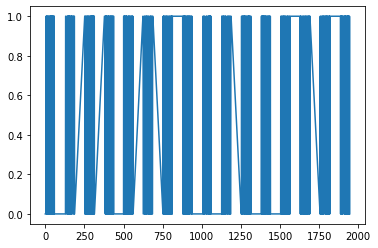

In [17]:
# Printing of a plot for understanding the values' range
#df_0['stock_price'].plot()
df_0['change_from_yesterday'].plot()

In [18]:
# create DataSets

# Split the data into test and training sets (and independent and dependent variables)
from sklearn.model_selection import train_test_split
target = df_0['change_from_yesterday']
print(target)
df_0_new = df_0.copy()
df_0_new.drop('change_from_yesterday', inplace=True, axis=1)

train_X, test_X, train_y, test_y = train_test_split(df_0_new, target, test_size=0.20)

#q: are we predicting from day to day?
#q: are we suposed to look at the preious day, compare it with today, 
#get a binary output and use that as the target prediction?

0       0
1       0
2       0
3       0
4       0
       ..
1941    1
1942    0
1943    0
1944    1
1945    0
Name: change_from_yesterday, Length: 1004, dtype: int64


In [19]:
print(train_X.values.shape)
print(train_y.values.shape)

print(test_X.values.shape)
print(test_y.values.shape)




(803, 14)
(803,)
(201, 14)
(201,)


In [20]:
# conversion the independent and dependent data of the training set into two 
# separate tensor that we pass to a TensorDataset
X = torch.tensor(train_X.values, dtype=torch.float)
y = torch.tensor(train_y.values, dtype=torch.int64)
train_ds = torch.utils.data.TensorDataset(X, y)
'''
X = torch.tensor(test_X.values, dtype=torch.float)
y = torch.tensor(test_y.values, dtype=torch.int64)
test_ds = torch.utils.data.TensorDataset(X, y)
'''
X = torch.tensor(test_X.values, dtype=torch.float)
y = torch.tensor(test_y.values, dtype=torch.int64)
test_ds = torch.utils.data.TensorDataset(X, y)

In [21]:
# Create dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=100, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=100, shuffle=False)

In [22]:
import torch
import torch.nn as nn

class Network(nn.Module):
  
  def __init__(self):

    super().__init__()

    self.hidden = nn.Linear(14, 28)
    self.relu = nn.ReLU()

    self.output = nn.Linear(28, 2)  
    self.softMax = nn.LogSoftmax(dim=-1)
    return


  def forward(self, x):

    x = self.hidden(x)
    x = self.relu(x)

    x = self.output(x)
    x = self.softMax(x)
    return x

In [ ]:
def train_helper_function(dataset):
  for epochs in range(10):
    for data in dataset:
      X, y = data
      optimizer.zero_grad() # clear gradient information.
      output = model(X.view(-1, 14))
      loss = nn.functional.nll_loss(output, y)
      loss.backward() # do pack-propagation step
      optimizer.step() # update weights.

In [24]:
model = Network()

# Train my neural network.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_helper_function(train_dl_0)
train_helper_function(train_dl_1)
train_helper_function(train_dl_2)

In [25]:
# definition of Predictor object
predictor_name = 'marketPredictor'
net = model
predictor = predictor.Predictor(predictor_name, net)

In [ ]:
simulator.simulate(2017, 5, predictor)